In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Modelado

In [2]:
import cv2
import numpy
import pandas
#import imageio.v3 as io

#from tqdm import tqdm
from typing import Optional, Union
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
%matplotlib inline


# Train

In [3]:
# Comprobamos a abrirlos de nuevo /content/drive/MyDrive/datos/filtered_data_Test.csv
saved_data_Train = pandas.read_csv("/content/drive/MyDrive/datos/nuevo/filtered_data_Train.csv", sep=';')
saved_imgs_Train = numpy.load("/content/drive/MyDrive/datos/nuevo/imageTrain.npy")
saved_data_Train.shape, saved_imgs_Train.shape

((6762, 14), (6762, 224, 224, 3))

In [4]:
y_train = saved_data_Train.iloc[:, 0:1]   # Seleccionamos la primera columna, price
X_train = saved_data_Train.iloc[:, 1:-1]  # Seleccionamos todas las columnas excepto la primera y la última

scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

X_train = XtrainScaled

# Test

In [5]:
# Comprobamos a abrirlos de nuevo
saved_data_Test = pandas.read_csv("/content/drive/MyDrive/datos/nuevo/filtered_data_Test.csv", sep=';')
saved_imgs_Test = numpy.load("/content/drive/MyDrive/datos/nuevo/imagesTest.npy")
saved_data_Test.shape, saved_imgs_Test.shape

((852, 14), (852, 224, 224, 3))

In [6]:
y_test = saved_data_Test.iloc[:, 0:1]      # nos quedamos con la 1ª columna, price
X_test = saved_data_Test.iloc[:,1:-1]      # nos quedamos con el resto


# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
XtestScaled = scaler.transform(X_test)
X_test = XtestScaled

# Validacion

In [7]:
# Comprobamos a abrirlos de nuevo
saved_data_Val = pandas.read_csv("/content/drive/MyDrive/datos/nuevo/filtered_data_Val.csv", sep=';')
saved_imgs_Val = numpy.load("/content/drive/MyDrive/datos/nuevo/imagesVal.npy")
saved_data_Val.shape, saved_imgs_Val.shape

((839, 14), (839, 224, 224, 3))

In [8]:
y_val = saved_data_Val.iloc[:,0:1]     # nos quedamos con la 1ª columna, price
X_val = saved_data_Val.iloc[:,1:-1]      # nos quedamos con el resto


# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
XvalScaled = scaler.transform(X_val)

X_val = XvalScaled

Así, por ejemplo, cargamos y visualizamos la distribución de las etiquetas:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6762 entries, 0 to 6761
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Price              6762 non-null   float64
 1   Zipcode            6762 non-null   int64  
 2   Accommodates       6762 non-null   int64  
 3   Bathrooms          6762 non-null   float64
 4   Bedrooms           6762 non-null   float64
 5   Beds               6762 non-null   float64
 6   Security Deposit   6762 non-null   float64
 7   Cleaning Fee       6762 non-null   float64
 8   Guests Included    6762 non-null   int64  
 9   Extra People       6762 non-null   int64  
 10  Minimum Nights     6762 non-null   int64  
 11  Maximum Nights     6762 non-null   int64  
 12  Number of Reviews  6762 non-null   int64  
 13  Thumbnail Url      6762 non-null   object 
dtypes: float64(6), int64(7), object(1)
memory usage: 739.7+ KB


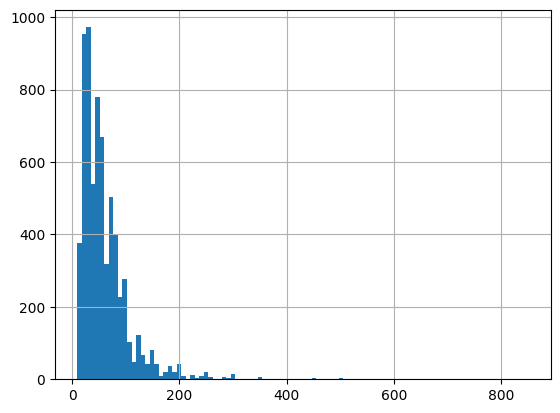

In [9]:
saved_data_Train['Price'].hist(bins=100)
saved_data_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852 entries, 0 to 851
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Price              852 non-null    float64
 1   Zipcode            852 non-null    int64  
 2   Accommodates       852 non-null    int64  
 3   Bathrooms          852 non-null    float64
 4   Bedrooms           852 non-null    float64
 5   Beds               852 non-null    float64
 6   Security Deposit   852 non-null    float64
 7   Cleaning Fee       852 non-null    float64
 8   Guests Included    852 non-null    int64  
 9   Extra People       852 non-null    int64  
 10  Minimum Nights     852 non-null    int64  
 11  Maximum Nights     852 non-null    int64  
 12  Number of Reviews  852 non-null    int64  
 13  Thumbnail Url      852 non-null    object 
dtypes: float64(6), int64(7), object(1)
memory usage: 93.3+ KB


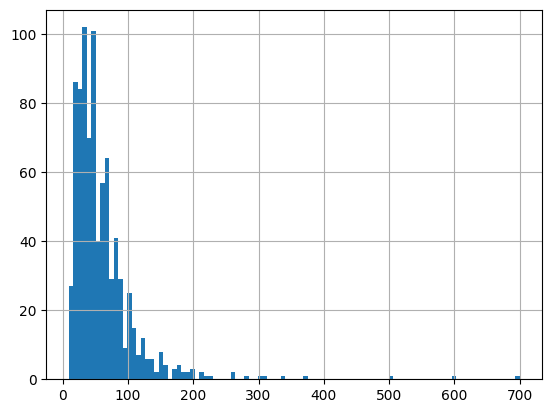

In [10]:
saved_data_Test['Price'].hist(bins=100)
saved_data_Test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839 entries, 0 to 838
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Price              839 non-null    float64
 1   Zipcode            839 non-null    int64  
 2   Accommodates       839 non-null    int64  
 3   Bathrooms          839 non-null    float64
 4   Bedrooms           839 non-null    float64
 5   Beds               839 non-null    float64
 6   Security Deposit   839 non-null    float64
 7   Cleaning Fee       839 non-null    float64
 8   Guests Included    839 non-null    int64  
 9   Extra People       839 non-null    int64  
 10  Minimum Nights     839 non-null    int64  
 11  Maximum Nights     839 non-null    int64  
 12  Number of Reviews  839 non-null    int64  
 13  Thumbnail Url      839 non-null    object 
dtypes: float64(6), int64(7), object(1)
memory usage: 91.9+ KB


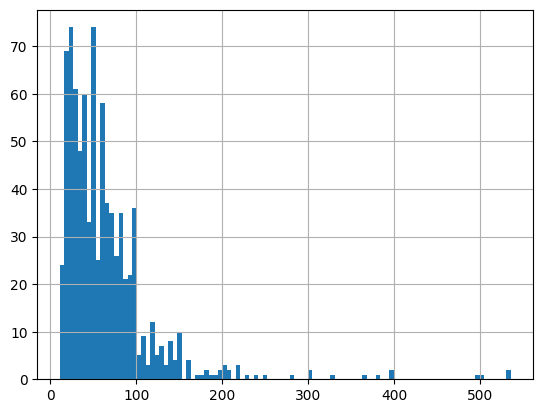

In [11]:
saved_data_Val['Price'].hist(bins=100)
saved_data_Val.info()

# Modelo

In [12]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [13]:
# Verificar si hay una GPU disponible
print(tf.config.list_physical_devices('GPU'))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar el uso de la memoria GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        # Establecer el dispositivo GPU visible para Keras
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("GPU disponible y configurada correctamente")
    except:
        print("Error al configurar la GPU")
else:
    print("No se detectó ninguna GPU")


[]
No se detectó ninguna GPU


In [14]:
# Cargar los datos
X_train_img = saved_imgs_Train
X_test_img = saved_imgs_Test
X_val_img = saved_imgs_Val

La arquitectura ResNet50 esta disenada para clasificar sinembardo la utilizare en mi tarea de regresion. Quitando la salida de clasificacion sera reemplazado por una capa con unasa neurona sin activacion.

In [ ]:
# Descargar el modelo ResNet50 sin las capas densas
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas base
for layer in base_model.layers:
    layer.trainable = False

# Agregar nuevas capas densas al modelo
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1)(x)

# Definir el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Definir el learning rate deseado
learning_rate = 0.0001
# Compilar el modelo utilizando el optimizador Adam con el learning rate especificado
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

#Mostrar las capas
model.summary()

# Definir el nombre del archivo para guardar el mejor modelo
checkpoint_filepath = '/content/drive/MyDrive/datos/nuevo/mejor_modelo.h5'
# Crear el callback ModelCheckpoint
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
# Entrenar el modelo con el callback ModelCheckpoint
history = model.fit(X_train_img, y_train, validation_data=(X_val_img, y_val), epochs=10, batch_size=64, callbacks=[checkpoint])




94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cargar el mejor modelo guardado
best_model = tf.keras.models.load_model('/content/drive/MyDrive/datos/nuevo/mejor_modelo.h5')
# Obtener el historial de entrenamiento del mejor modelo
best_model_history = history.history

# Obtener las métricas de entrenamiento y validación del mejor modelo
train_loss = best_model_history['loss']
val_loss = best_model_history['val_loss']
#train_mse = best_model_history['mse']
#val_mse = best_model_history['val_mse']

# Mostrar gráfica de loss y métrica de entrenamiento y validación
plt.style.use("ggplot")
num_epochs =10
# Gráfico de pérdida
plt.figure()
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_loss, label="train_loss")
plt.plot(epochs, val_loss, label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Gráfico de métricas
'''plt.figure()
plt.plot(epochs, train_mse, label="train_mse")
plt.plot(epochs, val_mse, label="val_mse")
plt.title("Training and Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()'''
# Evaluamos el modelo en los datos de prueba
print("[INFO]: Evaluando red neuronal...")
y_pred = best_model.predict(X_test_img)

# Calculamos las métricas de regresión
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimimos las métricas
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)